In [120]:
import os
from netCDF4 import Dataset
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import datetime

In [103]:
dataframes = []

def calc_nino(SST_data):
    
    file = Dataset(SST_data, 'r')
    # Open netcdf file
    ds = xr.open_dataset(SST_data, decode_times=False)

    # Fix Dates to Match File
    reference_date = pd.to_datetime("1850-01-01")
    start_date = reference_date + datetime.timedelta(days = float(ds.time[0]))
    ds['time'] = pd.date_range(start=start_date, periods=ds.sizes['time'], freq='MS')

    # Select Niño 3.4 region (5N-5S, 170W-120W)
    ds_nino34 = ds.sel(lat=slice(-5, 5), lon=slice(190, 240))

    # Calculate area-weighted mean SST
    weights = np.cos(np.deg2rad(ds_nino34.lat))
    weights.name = 'weights'
    ds_weighted = ds_nino34['SST'].weighted(weights)
    mean_sst = ds_weighted.mean(dim=['lat', 'lon'])
    ds_nino34 = mean_sst

    # Select Jul-Oct
    month_list = [True if month in [7,8,9,10] else False for month in ds['time.month']]
    ds_nino34 = ds_nino34.loc[{'time' : month_list}] 

    # Calculate temporal mean
    ds_nino34 = ds_nino34.groupby('time.year').mean()

    dataframes.append(pd.DataFrame({'year': np.array(ds_nino34.coords['year']), 'Average_SST': np.array(ds_nino34), 'Sim': [file.__dict__['case'][-8:]]*len(ds_nino34)}))
   # SST_Nino_Averages.append(nino34)

directory_path = "/Users/michaelvaden/Downloads/SST_Files/"

# Iterate through each file in the directory
for filename in os.listdir(directory_path):
    if filename.endswith(".nc"):
        file_path = os.path.join(directory_path, filename)
        calc_nino(file_path)

In [118]:
nino_data = pd.concat(dataframes)
nino_data.groupby(['Sim', 'year']).sum()

Average_SST
Sim      year             
1001.001 1940   300.755161
         1941   300.476758
         1942   302.393693
         1943   298.560676
         1944   300.111834
...                    ...
1301.020 2010   301.778526
         2011   298.295271
         2012   299.273569
         2013   300.534646
         2014   302.049748

[7500 rows x 1 columns]

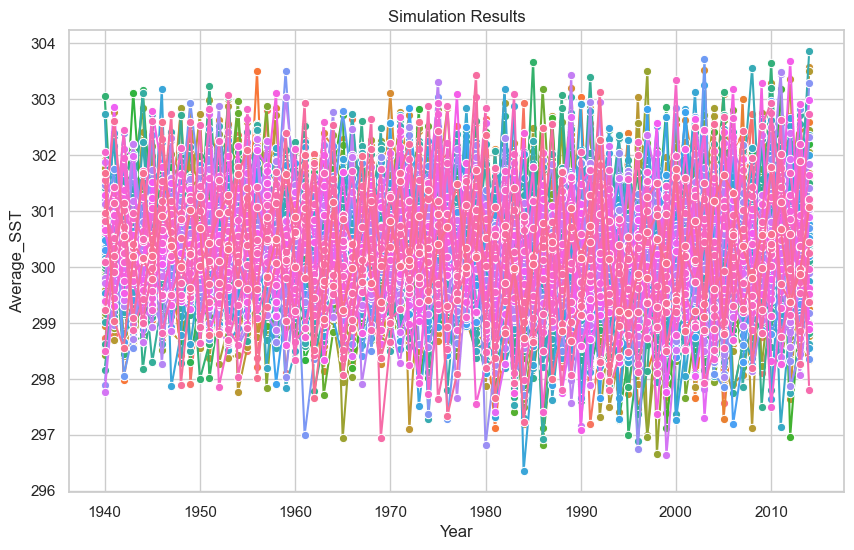

In [130]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='Average_SST', hue='Sim', data=nino_data, marker='o')

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('Average_SST')
plt.title('Simulation Results')
plt.legend([],[], frameon=False)

plt.show()